In [19]:
import json
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np

In [20]:
infile = open('FEM_converted.json', 'r')

In [21]:
var_dict = json.load(infile)

In [22]:
infile.close()

In [23]:
E = var_dict["E"]
nu = var_dict["nu"]
nnode = var_dict["nnode"]
xcoord = np.asarray([i[0] for i in var_dict["coord"]])
ycoord = np.asarray([i[1] for i in var_dict["coord"]])
nelem = var_dict["nelem"]
connect = var_dict["connect"]
nfix = var_dict["nfix"]
fixnodes = var_dict["fixnodes"]
ndload = var_dict["ndload"]
dloads = var_dict["dloads"]

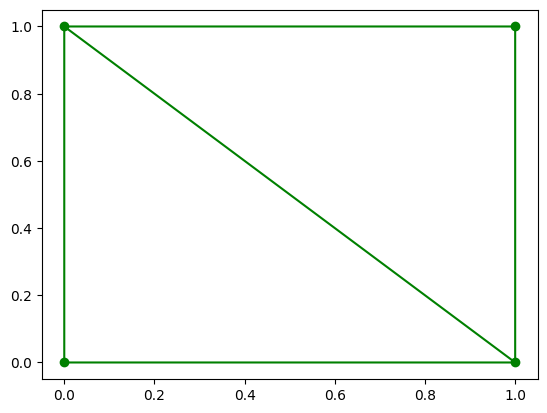

In [24]:
fig, ax = plt.subplots()
triang = mtri.Triangulation(xcoord, ycoord, connect)
plt.triplot(triang, 'go-', ax)

In [25]:
def create_Dmat(nu, E):
    return E/((1+nu)*(1-2*nu)) * np.asarray([[1-nu,nu,0],[nu,1-nu,0],[0,0,(1-2*nu)/2]])

In [26]:
Dmat = create_Dmat(nu, E)

In [27]:
Stif = np.zeros((2*nnode, 2*nnode))

In [28]:
def elstif(xa,ya,xb,yb,xc,yc,Dmat):
    # Define B matrix
    nax = -(yc-yb)/( (ya-yb)*(xc-xb) - (xa-xb)*(yc-yb) )
    nay =  (xc-xb)/( (ya-yb)*(xc-xb) - (xa-xb)*(yc-yb) )
    nbx = -(ya-yc)/( (yb-yc)*(xa-xc) - (xb-xc)*(ya-yc) )
    nby =  (xa-xc)/( (yb-yc)*(xa-xc) - (xb-xc)*(ya-yc) )
    ncx = -(yb-ya)/( (yc-ya)*(xb-xa) - (xc-xa)*(yb-ya) )
    ncy =  (xb-xa)/( (yc-ya)*(xb-xa) - (xc-xa)*(yb-ya) )
    area = (1/2)*np.abs( (xb-xa)*(yc-ya) - (xc-xa)*(yb-ya) )
    Bmat = np.asarray([[nax, 0, nbx, 0, ncx, 0],
                        [0, nay, 0, nby, 0, ncy],
                        [nay, nax, nby, nbx, ncy, ncx]])
    
    # Return element stiffness
    return area*np.dot(np.dot(np.transpose(Bmat), Dmat), Bmat)

In [29]:
for lmn in range(nelem):
    a = connect[lmn][0]
    b = connect[lmn][1]
    c = connect[lmn][2]
    k = elstif(xcoord[a], ycoord[a], xcoord[b], ycoord[b], xcoord[c], ycoord[c], Dmat)

    for i in range(3):
        for ii in range(2):
            for j in range(3):
                for jj in range(2):
                    rw = 2*(connect[lmn][i])+ii
                    cl = 2*(connect[lmn][j])+jj
                    Stif[rw][cl] = Stif[rw][cl] + k[2*i+ii][2*j+jj]

In [30]:
def elresid(xa, ya, xb, yb, tx, ty):
    length = np.sqrt((xa-xb)*(xa-xb)+(ya-yb)*(ya-yb))
    return np.asarray([tx,ty,tx,ty])*length/2

In [31]:
resid = np.zeros(2*nnode)

In [32]:
pointer = [1, 2, 0]
for i in range(ndload):
    lmn = dloads[i][0]
    face = dloads[i][1]
    a = connect[lmn][face]
    b = connect[lmn][pointer[face]]
    r = elresid(xcoord[a], ycoord[a], xcoord[b], ycoord[b], dloads[i][2], dloads[i][3])
    
    resid[2*a]=resid[2*a]+r[0]
    resid[2*a+1]=resid[2*a+1]+r[1]
    resid[2*b]=resid[2*b]+r[2]
    resid[2*b+1]=resid[2*b+1]+r[3]

In [33]:
for i in range(nfix):
    rw=2*(fixnodes[i][0])+fixnodes[i][1]
    for j in range(2*nnode):
        Stif[rw][j] = 0
    Stif[rw][rw] = 1.0
    resid[rw]=fixnodes[i][2]

In [34]:
V, D = np.linalg.eig(Stif)
eigenvecs = np.transpose(V)
eigenvals = D
u = np.linalg.solve(Stif, resid)

In [35]:
uxcoord = np.zeros(nnode)
uycoord = np.zeros(nnode)
for i in range(nnode):
    uxcoord[i] = xcoord[i] + u[2*i]
    uycoord[i] = ycoord[i] + u[2*i+1]

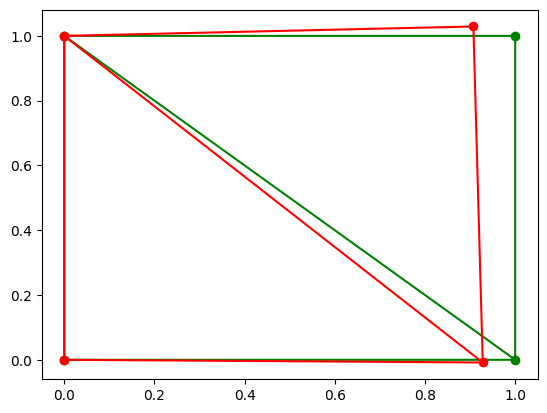

In [36]:
triang2 = mtri.Triangulation(uxcoord, uycoord, connect)
plt.triplot(triang, 'go-', ax)
plt.triplot(triang2, 'ro-', ax)